In [8]:
import torch
from d2l import d2l

img = d2l.plt.imread("./imgs/catdog.png")
h, w = img.shape[:2]
h, w

(561, 728)

In [15]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # 前两个维度上的值不影响输出
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0] * bbox_scale)
    print(anchors[0][0])
    print((anchors[0] * bbox_scale)[0])

tensor([0.0500, 0.0500, 0.2000, 0.2000])
tensor([ 36.4000,  28.0500, 145.6000, 112.2000])


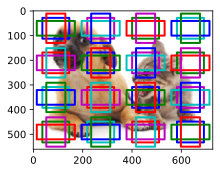

In [16]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

tensor([0.0500, 0.0500, 0.4500, 0.4500])
tensor([ 36.4000,  28.0500, 327.6000, 252.4500])


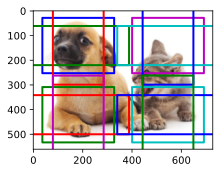

In [4]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

tensor([0.1000, 0.1000, 0.9000, 0.9000])
tensor([ 72.8000,  56.1000, 655.2000, 504.9000])


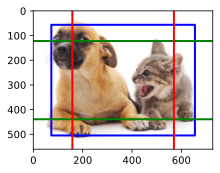

In [20]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

In [6]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import d2l


def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(
        num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1
    )

In [7]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [8]:
def forward(x, block):
    return block(x)


Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [23]:
# 通道维度放到最后 让每个像素的预测值挨在一起
a = torch.arange(18).repeat(2).reshape(2, 2, 3, 3)
print(a)
print(a.permute(0, 2, 3, 1))  # 1,3,3,2
print(torch.flatten(a.permute(0, 2, 3, 1), start_dim=1))

tensor([[[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8]],

         [[ 9, 10, 11],
          [12, 13, 14],
          [15, 16, 17]]],


        [[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8]],

         [[ 9, 10, 11],
          [12, 13, 14],
          [15, 16, 17]]]])
tensor([[[[ 0,  9],
          [ 1, 10],
          [ 2, 11]],

         [[ 3, 12],
          [ 4, 13],
          [ 5, 14]],

         [[ 6, 15],
          [ 7, 16],
          [ 8, 17]]],


        [[[ 0,  9],
          [ 1, 10],
          [ 2, 11]],

         [[ 3, 12],
          [ 4, 13],
          [ 5, 14]],

         [[ 6, 15],
          [ 7, 16],
          [ 8, 17]]]])
tensor([[ 0,  9,  1, 10,  2, 11,  3, 12,  4, 13,  5, 14,  6, 15,  7, 16,  8, 17],
        [ 0,  9,  1, 10,  2, 11,  3, 12,  4, 13,  5, 14,  6, 15,  7, 16,  8, 17]])


In [10]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)


def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)


concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [11]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)


forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [12]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)


# 第一次锚框是在32x32
forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [13]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [14]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [15]:
# 超参数
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1